# Movielens 영화 추천
- MF 모델 학습 방법으로 내가 좋아할 만한 영화 추천 시스템 제작하기
- 데이터셋 : Movielens 데이터

## 순서

1. 데이터 준비와 전처리
2. 분석
- ratings에 있는 유니크한 영화 개수
- rating 에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

3. 선호하는 영화 rating에 추가하기
4. CSR matrix 만들기
5. als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련
6. 선호하는 영화들 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도 파악하기
7. 가장 좋아하는 영화와 비슷한 영화 추천받기
8. 가장 좋아할 만한 영화들 추천받기

### 1) 데이터 준비와 전처리
- Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리

In [53]:
import pandas as pd
import os
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

rating_file_path=os.getenv('HOME') + '/aiffel/AIFFEL_PROJECT/EXPLORATION_9/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 2) 분석
- rating 가 3점 이상인 것들만 남기고 나머지는 제외한다
- ratings에 있는 유니크한 영화 개수
- rating에 있는 유니크한 사용자 수
- 가장 인기 많은 영화 장르&영화 
- 유저별 평점 통계
- 가장 인기 있는 영화 30개(인기순)

In [54]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [55]:
# rating 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'rating':'count'}, inplace=True)

In [56]:
ratings['count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

In [57]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/AIFFEL_PROJECT/EXPLORATION_9/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [58]:
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [60]:
pd.set_option('display.max_rows', 3883) ##전체 movie 행 다 나오게

In [62]:
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
#user_id에 포함된 유니크한 데이터의 개수
ratings['user_id'].nunique()

6039

In [10]:
#movie_id에 포함된 유니크한 데이터의 개수
ratings['movie_id'].nunique()

3628

In [11]:
data=pd.merge(ratings,movies,how='left',on='movie_id')
data.head()

,user_id,movie_id,count,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [12]:
#인기 많은 영화장르
#Drama 가 가장 인기 많다
genre_count=data.groupby('genre')['user_id'].count()
genre_count.sort_values(ascending=False).head(30)

genre
Drama                               99388
Comedy                              94264
Comedy|Drama                        36871
Comedy|Romance                      35888
Drama|Romance                       24835
Action|Thriller                     22675
Drama|Thriller                      16133
Horror                              15260
Thriller                            14925
Action|Adventure|Sci-Fi             14277
Drama|War                           13766
Action|Sci-Fi|Thriller              11657
Action|Drama|War                    11316
Crime|Drama                         10960
Action|Sci-Fi                       10594
Action                               9930
Comedy|Drama|Romance                 9804
Action|Adventure                     8744
Action|Drama                         8611
Comedy|Sci-Fi                        7797
Comedy|Horror                        7523
Animation|Children's                 7461
Animation|Children's|Musical         7237
Animation|Children's|Comedy 

In [13]:
#가장 많이 본 영화 순위
user_count=data.groupby('title')['user_id'].count()
user_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

In [14]:
#유저별 평점 통계
count_mean=data.groupby('count')['user_id'].mean()
count_mean.sort_values(ascending=False).head(30)

count
5    3053.832208
4    3027.922042
3    3022.120947
Name: user_id, dtype: float64

In [15]:
using_cols=['user_id','title','count']
data=data[using_cols]
data.head(10)

,user_id,title,count
0,1,One Flew Over the Cuckoo's Nest (1975),5
1,1,James and the Giant Peach (1996),3
2,1,My Fair Lady (1964),3
3,1,Erin Brockovich (2000),4
4,1,"Bug's Life, A (1998)",5
5,1,"Princess Bride, The (1987)",3
6,1,Ben-Hur (1959),5
7,1,"Christmas Story, A (1983)",5
8,1,Snow White and the Seven Dwarfs (1937),4
9,1,"Wizard of Oz, The (1939)",4


### 3) 선호하는 영화 rating에 추가하기
아는 영화가 정말 몇 개 없어서 처음엔 내가 좋아하는지에 상관없이 아는 이름의 영화들만 넣었다가 제대로 된 분석 결과가 나오지 않아서 비슷한 장르의 영화 10개를 넣었다.
my_favorite=
['American President, The (1995)','Toy Story(1995)','It Takes Two (1995)','Waiting for Guffman (1996)','That Old Feeling (1997)','Home Alone 3 (1997)','Little City (1998)','Black Cauldron, The (1985)','Antz (1998)','History of the World: Part I (1981)']

In [16]:
#my_favorite=['Toy Story(1995)','Forrest Gump(1994)','Endless Summer 2, The(1994)','Home Alone(1990)','Terminator 2:Judgment Day(1991)','One Fine Day(1996)','Two Family House(2000)']

#my_rating=pd.DataFrame({'user_id':['ke']*7,'title':my_favorite,'count':[5]*7})

#if not data.isin({'user_id':['ke']})['user_id'].any():
#    data=data.append(my_rating)
    
#data.tail(10)

In [17]:
my_favorite=['American President, The (1995)','Toy Story(1995)','It Takes Two (1995)','Waiting for Guffman (1996)','That Old Feeling (1997)','Home Alone 3 (1997)','Little City (1998)','Black Cauldron, The (1985)','Antz (1998)','History of the World: Part I (1981)']

my_rating=pd.DataFrame({'user_id':['ke']*10,'title':my_favorite,'count':[5]*10})

if not data.isin({'user_id':['ke']})['user_id'].any():
    data=data.append(my_rating)
    
data.tail(10)

,user_id,title,count
0,ke,"American President, The (1995)",5
1,ke,Toy Story(1995),5
2,ke,It Takes Two (1995),5
3,ke,Waiting for Guffman (1996),5
4,ke,That Old Feeling (1997),5
5,ke,Home Alone 3 (1997),5
6,ke,Little City (1998),5
7,ke,"Black Cauldron, The (1985)",5
8,ke,Antz (1998),5
9,ke,History of the World: Part I (1981),5


In [18]:
#고유한 유저와 고유한 영화 title 확인
user_unique = data['user_id'].unique()
title_unique = data['title'].unique()

# 유저, 영화title indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

In [19]:
print(user_to_idx['ke'])    
print(title_to_idx['Toy Story(1995)'])

6039
3628


In [20]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# title_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = data['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(data):
    print('title column indexing OK!!')
    data['title'] = temp_title_data
else:
    print('title column indexing Fail!!')

data

##data의 user_id와 artist 컬럼 내 값들이 모두 정수 인덱스 값으로 잘 변경되었나요? 이것으로 훈련을 위한 전처리가 완료

user_id column indexing OK!!
title column indexing OK!!


,user_id,title,count
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5
...,...,...,...
5,6039,1994,5
6,6039,3100,5
7,6039,705,5
8,6039,30,5


### 4)CSR matrix 만들기

In [21]:
#CSR(Compressed Sparse Row) Matrix

num_user = data['user_id'].nunique()
num_title = data['title'].nunique()

csr_data = csr_matrix((data['count'], (data.user_id, data.title)), shape= (num_user, num_title))
csr_data

<6040x3629 sparse matrix of type '<class 'numpy.longlong'>'
	with 836488 stored elements in Compressed Sparse Row format>

### 5) MF 모델 학습하기
- implicit 패키지에 구현된 als(AlternatingLeastSquares) 모델사용
- Matrix Factorization 에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식사용

In [22]:
# MF모델 학습하기
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [23]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=300, regularization=0.01, use_gpu=False, iterations=20, dtype=np.float32)

In [24]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3629x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836488 stored elements in Compressed Sparse Column format>

In [25]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/20 [00:00<?, ?it/s]

### 6) 내가 선호하는 10가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도 파악

In [26]:
ke, toy_story = user_to_idx['ke'], title_to_idx['Toy Story(1995)']
ke_vector, toy_story_vector = als_model.user_factors[ke], als_model.item_factors[toy_story]

print('슝=3')

슝=3


In [27]:
ke_vector

array([-0.02206397, -0.02334103,  0.27001694,  0.0925822 , -0.33954006,
        0.20651211, -0.6401163 , -0.50496584, -0.04825611, -0.0861173 ,
       -0.3552618 ,  0.12447911,  0.17712845, -0.57023793, -0.02771022,
       -0.13146433, -0.83761084, -0.95509785,  0.26809758, -0.3174297 ,
       -0.39219967, -0.06554808,  0.1272477 , -0.19149442,  0.02526887,
        0.13990046, -0.29935485, -0.64620024, -0.5549406 , -0.18663912,
        0.39751446,  0.06571957, -0.16169353,  0.61289346,  0.05081168,
       -0.1324445 ,  0.14852974,  1.0547314 , -0.05598395,  0.71414155,
       -0.3245267 , -0.02096114, -0.22217928,  0.06299257, -0.8278732 ,
        0.30677813, -0.6353469 , -0.22022305,  0.05886415,  0.08498915,
       -1.3270755 , -0.26682985,  0.44363216,  0.39424565, -0.7380852 ,
        0.2741036 , -0.3045379 , -0.73535466,  0.19142304,  0.5751743 ,
        0.22165142, -0.24251603,  0.9919971 ,  0.373638  , -0.0602391 ,
        0.2541054 ,  0.06883937, -0.55617386,  0.659905  , -0.66

In [28]:
toy_story_vector

array([0.00477476, 0.0036201 , 0.00462833, 0.00423283, 0.00277234,
       0.00628978, 0.00447856, 0.00453483, 0.00343015, 0.00262596,
       0.00395963, 0.00306063, 0.00557763, 0.00513011, 0.00425887,
       0.00443588, 0.00387027, 0.00411158, 0.00402219, 0.00032554,
       0.0043886 , 0.00523394, 0.00515893, 0.00523219, 0.0056746 ,
       0.00319004, 0.00489524, 0.00162897, 0.00431174, 0.00516246,
       0.00416158, 0.00284168, 0.00494609, 0.00201733, 0.00501003,
       0.00459663, 0.00626691, 0.00359746, 0.0053317 , 0.00458011,
       0.00620969, 0.00168711, 0.00173378, 0.00551802, 0.00153121,
       0.00250983, 0.00259634, 0.00323709, 0.0055408 , 0.00405329,
       0.00480792, 0.00509419, 0.00420627, 0.00510163, 0.00416527,
       0.00676294, 0.00388766, 0.00387023, 0.00384057, 0.0037539 ,
       0.00449002, 0.00413727, 0.0047662 , 0.00600197, 0.00607098,
       0.00397153, 0.00430957, 0.00251514, 0.00639546, 0.00364186,
       0.00421117, 0.00423831, 0.00535733, 0.00466492, 0.00438

In [29]:
# 내가 좋아하는 영화의 genre표시
movies[movies['title'].isin(['American President, The (1995)','Toy Story (1995)','It Takes Two (1995)','Waiting for Guffman (1996)','That Old Feeling (1997)','Home Alone 3 (1997)','Little City (1998)','Black Cauldron, The (1985)','Antz (1998)','History of the World: Part I (1981)'])]

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
10,11,"American President, The (1995)",Comedy|Drama|Romance
37,38,It Takes Two (1995),Comedy
1424,1449,Waiting for Guffman (1996),Comedy
1436,1463,That Old Feeling (1997),Comedy|Romance
1659,1707,Home Alone 3 (1997),Children's|Comedy
1724,1782,Little City (1998),Comedy|Romance
1964,2033,"Black Cauldron, The (1985)",Animation|Children's
2225,2294,Antz (1998),Animation|Children's
2232,2301,History of the World: Part I (1981),Comedy


In [31]:
# ke과 toy_story를 내적하는 코드
np.dot(ke_vector,toy_story_vector)  #매우 낮은 수치

0.0488178

In [32]:
home_alone=title_to_idx['Home Alone 3 (1997)']
home_alone_vector=als_model.item_factors[home_alone]
np.dot(ke_vector, home_alone_vector)

0.16349624

In [33]:
history=title_to_idx['History of the World: Part I (1981)']
history_vector=als_model.item_factors[history]
np.dot(ke_vector, history_vector)

0.48276034

In [49]:
two=title_to_idx['It Takes Two (1995)']
two_vector=als_model.item_factors[two]
np.dot(ke_vector, two_vector)

0.10537991

In [50]:
president=title_to_idx['American President, The (1995)']
president_vector=als_model.item_factors[history]
np.dot(ke_vector, president_vector)

0.7472468

In [41]:
# 내가 선호하지 않는 horror 장르 영화
blood=title_to_idx['Bay of Blood (Reazione a catena) (1971)']
blood_vector=als_model.item_factors[blood]
np.dot(ke_vector, blood_vector)

0.01133021

### 7) 내가 좋아하는 영화와 비슷한 영화 추천받기
비슷한 장르의 영화들을 추천받음.

In [35]:
idx_to_title = {v:k for k,v in title_to_idx.items()}

def get_similar_movie(title_name: str):
    movie_id = title_to_idx[title_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_title[i[0]] for i in similar_movie]
    return similar_movie

print("슝=3")

슝=3


In [36]:
get_similar_movie('Toy Story(1995)')

['Toy Story(1995)',
 'Chain of Fools (2000)',
 'Aiqing wansui (1994)',
 'Sunchaser, The (1996)',
 'Make Them Die Slowly (Cannibal Ferox) (1980)',
 'For Ever Mozart (1996)',
 'Loser (1991)',
 'Open Season (1996)',
 'Song of Freedom (1936)',
 '1-900 (1994)']

In [42]:
get_similar_movie('American President, The (1995)')

['American President, The (1995)',
 'Dave (1993)',
 'Adventures of Elmo in Grouchland, The (1999)',
 'Sleepless in Seattle (1993)',
 'Education of Little Tree, The (1997)',
 'Hollow Reed (1996)',
 'Air Bud: Golden Receiver (1998)',
 'Different for Girls (1996)',
 "Enfer, L' (1994)",
 'Glass Shield, The (1994)']

### 8) 내가 가장 좋아할 만한 영화들 추천받기
- comedy 위주의 영화를 추천받았다.

In [38]:
user = user_to_idx['ke']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(1331, 0.2955079),
 (752, 0.25040925),
 (466, 0.24952194),
 (145, 0.21652757),
 (841, 0.1910955),
 (384, 0.1897675),
 (1158, 0.18512625),
 (301, 0.18218118),
 (444, 0.17784059),
 (641, 0.1729042),
 (1635, 0.17139664),
 (790, 0.17031124),
 (303, 0.17028248),
 (15, 0.16260931),
 (48, 0.1553458),
 (308, 0.15442672),
 (467, 0.15176633),
 (277, 0.15023352),
 (413, 0.14888275),
 (238, 0.1483086)]

In [39]:
[idx_to_title[i[0]] for i in movie_recommended]

['Real Genius (1985)',
 'Wag the Dog (1997)',
 'Wedding Singer, The (1998)',
 'Fifth Element, The (1997)',
 'Prince of Egypt, The (1998)',
 'Jerry Maguire (1996)',
 'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)',
 'Rushmore (1998)',
 'High Fidelity (2000)',
 "Mr. Holland's Opus (1995)",
 'Dinosaur (2000)',
 'Birdcage, The (1996)',
 'Dick (1999)',
 'Airplane! (1980)',
 'Saving Private Ryan (1998)',
 'Bullets Over Broadway (1994)',
 'Cape Fear (1991)',
 'Babe: Pig in the City (1998)',
 'Akira (1988)',
 'Thin Red Line, The (1998)']

In [44]:
# 내가 좋아하는 영화의 genre표시
movies[movies['title'].isin(['Real Genius (1985)','Wag the Dog (1997)','Wedding Singer, The (1998)','Waiting for Guffman (1996)','Fifth Element, The (1997)','Prince of Egypt, The (1998)','Jerry Maguire (1996)','Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)','Rushmore (1998)','High Fidelity (2000)',"Mr. Holland's Opus (1995)",'Dinosaur (2000)','Birdcage, The (1996)','Dick (1999)','Airplane! (1980)','Saving Private Ryan (1998)','Bullets Over Broadway (1994)','Cape Fear (1991)','Babe: Pig in the City (1998)','Akira (1988)','Thin Red Line, The (1998)'])]

,movie_id,title,genre
61,62,Mr. Holland's Opus (1995),Drama
139,141,"Birdcage, The (1996)",Comedy
344,348,Bullets Over Broadway (1994),Comedy
464,468,"Englishman Who Went Up a Hill, But Came Down a...",Comedy|Romance
1254,1274,Akira (1988),Adventure|Animation|Sci-Fi|Thriller
1277,1297,Real Genius (1985),Comedy
1322,1343,Cape Fear (1991),Thriller
1372,1393,Jerry Maguire (1996),Drama|Romance
1424,1449,Waiting for Guffman (1996),Comedy
1491,1527,"Fifth Element, The (1997)",Action|Sci-Fi


# 회고
우선 내가 모르는 영화들이 너무 많고 다 보지 않은 영화들이어서 선택하기가 어려웠다. 그래서 처음에는 좋아하는 장르 상관없이 내가 아는 영화 이름들을 위주로 넣었는데 모델의 예측력이 현저히 떨어졌다.선호도가 0.1을 넘은 게 없었다.
- 처음 모델에 넣었던 영화리스트                                                 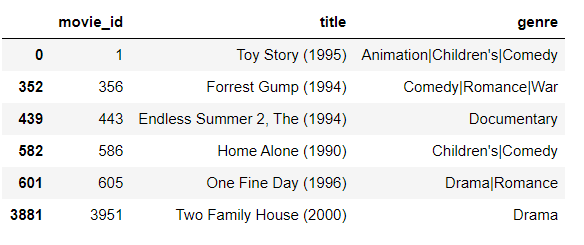

![image.png]
- 선호도 결과
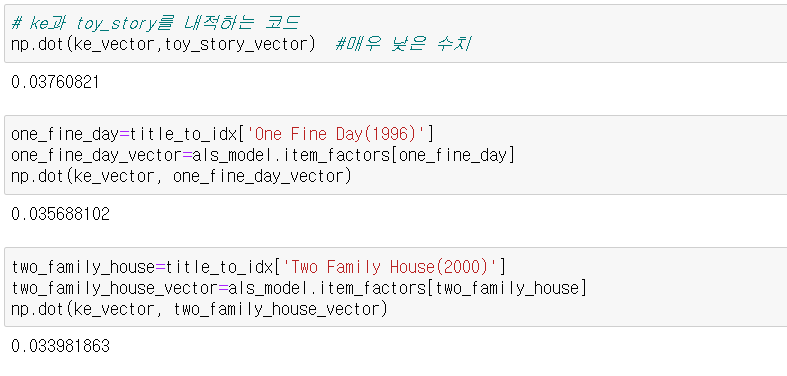

그래서 영화 리스트들을 비슷한 장르의 영화들을 위주로 넣었더니 선호도가 나름 정확하게 나왔다. 내가 좋아하는 장르가 comedy 여서 그 영화들을 위주로 모델에 넣었다. 
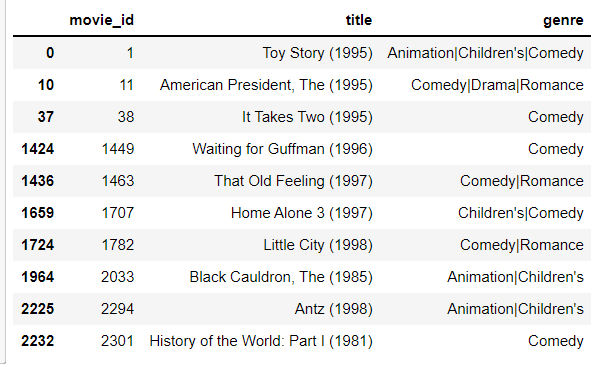
- 영화 선호도                                                                       
1) 내가 선호하는 영화들 중에 comedy 장르로 -'It Takes Two'를 선택했는데 선호도가 0.10537991 이 나왔다. comedy였지만 낮게 나와서 장르말고도 영화를 추천해주는 기준이 따로 있나 생각하게 되었다.                                                        
2) 내가 선호하지 않는 영화 장르가 horror인데 - 'Bay of Blood (Reazione a catena)' 선호도가 0.01133021로 낮게 나온 것을 보니 나름 정확했다.                        

- 내가 가장 좋아할 만한 영화 추천 받기                                               
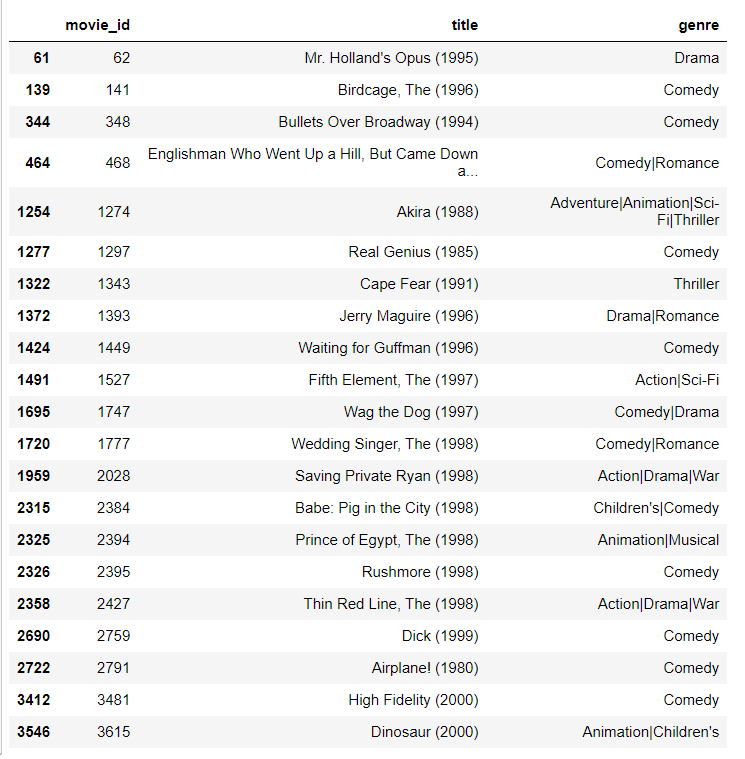

내가 좋아하는 영화와 비슷좋아할 만한 영화들의 장르들을 보니까 대부분 comedy 장르였다. 추천받은 영화이기 때문에 한 번 저 영화들을 봐보고 추천시스템이 정확한 지 확인해야겠다.